Vitber prosjekt: August Hardersen Skogøy, Markus Sandnes og Peder Aas Vårheim

I dette prosjektet skal man se nærmere på ulike maskinlæringsmetoder, og bruke disse til å klassifisere siffere fra null til ti. 

Maskinlæringsmetodene man skal se nærmere på er av typen "Dictionary learning", som enkelt forklart bruker et kjent bibliotek for å klassifisere ny data. De metodene vi skal bruke er "Singular Value Decomposition" ($\text{SVD}$) og "Exemplar-based Non-negative Matrix Factorization" ($\text{ENMF}$). Begge metodene bruker lineæralgebra til å danne en basis for de ulike datatypene, men på ulikt vis, som igjen gjør at metodene egner seg på ulike datasett. Vi skal gjennom prosjektet lage disse algoritmene, sjekke hvilke parametre som fungere best til ulike formål, og avslutningsvis bruke dette til å klassifisere rådata.

In [1]:
#Importerer nødvendige biblioteker
import numpy as np
import matplotlib.pyplot as plt
import random 
import time

For å klassifisere de ulike dataklassene må vi først lage en "dictionary" for hver klasse. Vi vil først benytte $\text{SVD}$-metoden, gitt ved formelen:

$$A = U\Sigma V^T$$

$\text{SVD}$-metoden tar inn en $m\times n$ matrise $A$ hvor hver kolonnevektor representerer rådata, og returner dette som tre ulike matriser, $U$,$\Sigma$ og $V^T$. $U$ er en $m\times m$ matrise som representerer de mest vanlige karaktertrekkene til datasettet langs kolonner i matrisen. $\Sigma$ er en diagonalmatrise med ulike singulærverdier, $\sigma_1,\sigma_2,...,\sigma_n$ langs diagonalen, som er sortert etter synkende rekkefølge. Disse verdiene forteller oss om viktigheten til tilhørende kolonnevektor i $U$. Altså vil alltid de første kolonnene i $U$ være de mest dominerende for datasettet. $V^T$ matrisen representerer kombinasjonen av de ulike kolonnevektorene som danner matrisen $A$.

Nedenfor bruker man noen enkle matriser $A_1$, for å teste hvordan $\text{SVD}$-metoden fungerer.

In [2]:
#1a)

# Lager matrise
A1 = np.array([[1000,1],[0,1],[0,0]])


# Tar SVD av matrisen, ved bruk av innebygde numpy fuksjoner
U_1,S_1,Vt_1 = np.linalg.svd(A1, full_matrices = False)


#np.linalg.svd returnerer sigma matrisen som en 1.D array, hvor hvert element i arrayen
# representerer en verdi i diagonalmatrisen. For å kunne bruke matrisemultiplikasjon må vi
# omgjøre arrayen tilbake til en diagonal matrise.

#Omgjøre arrayen til en diagonal matrise.
S_1_diag=np.diag(S_1)

#printer
print("Matrise A1:")
print(A1)
print(f"\nMatrisen til U ser ut som følger:")
print(U_1)
print(f"\nMatrisen til S ser ut som følger:")
print(S_1_diag)
print(f"\nMatrisen til V transponert ser ut som følger:")
print(Vt_1)
A_1 = np.dot(U_1,np.dot(S_1_diag,Vt_1))
print("\nA1 representert ved USV^T:")
print(A_1)

#Bruker np.allclose som sammenligner en matrise A med matrise B. Hvis matrisene er tilnærmet lik
# (innenfor en viss tolleranse), vil funksjonen returnere "True". Er de ikke det vil funksjonen 
# returnere false. Setter grensen på 10^(-18) og 10^(-20)

print(f"\nMatrisene er kompitable med en toleranse på 10^(-18): {np.allclose(A1,np.dot(U_1,np.dot(S_1_diag,Vt_1)),atol=1e-18)}")
print(f"Matrisene er kompitable med en toleranse på 10^(-20): {np.allclose(A1,np.dot(U_1,np.dot(S_1_diag,Vt_1)),atol=1e-20)}")

Matrise A1:
[[1000    1]
 [   0    1]
 [   0    0]]

Matrisen til U ser ut som følger:
[[ 1.e+00 -1.e-06]
 [ 1.e-06  1.e+00]
 [ 0.e+00  0.e+00]]

Matrisen til S ser ut som følger:
[[1.0000005e+03 0.0000000e+00]
 [0.0000000e+00 9.9999950e-01]]

Matrisen til V transponert ser ut som følger:
[[ 0.9999995  0.001    ]
 [-0.001      0.9999995]]

A1 representert ved USV^T:
[[ 1.00000000e+03  1.00000000e+00]
 [-2.06432094e-19  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]]

Matrisene er kompitable med en toleranse på 10^(-18): True
Matrisene er kompitable med en toleranse på 10^(-20): False


Ser at matrisen $A_1 = U \Sigma V^T = \begin{bmatrix} 1000 & 1\\ -2.168 \times 10^{-19} & 1 \\ 0 & 0 \end{bmatrix}$, er nesten helt lik startmatrisen $A_1 = \begin{bmatrix} 1000 & 1\\ 0 & 1 \\ 0 & 0 \end{bmatrix}$. Man har fått en liten feil i andre rad, første kolonne, pga. datamaskin-reprensenterte flyttall. For å rekonstruere $A_1$ er alltid første kolonne i $W_1 = U$ viktigst. Dette kan vi lett se i kodeblokken under.

In [3]:
#Lager kopierte variabler for å ikke endre på orginalverdi
U_c,S_c,Vt_c = np.copy(U_1), np.copy(S_1), np.copy(Vt_1)
S_c_diag=np.diag(S_c)
A1 = np.array([[1000,1],[0,1],[0,0]])

#Lager matrisen H_1 = 
H = np.dot(S_c_diag, Vt_c)
print( f"H = \n {H}") 
print(f"U = \n {U_c}")

H = 
 [[ 1.000000e+03  1.000001e+00]
 [-1.000000e-03  9.999990e-01]]
U = 
 [[ 1.e+00 -1.e-06]
 [ 1.e-06  1.e+00]
 [ 0.e+00  0.e+00]]


Når vi multipliserer disse matrisene sammen får man:
$$A_1 = U \left( \Sigma V^T \right) = U H = \begin{bmatrix} u_1 & u_2\\ u_3 & u_4 \\ u_5 & u_6 \end{bmatrix} \cdot \begin{bmatrix} h_1 & h_2\\ h_3 & h_4 \end{bmatrix} = \begin{bmatrix} u_1h_1 + u_2h_3 & u_1h_2 + u_2h_4\\ u_3h_1 + u_4h_3 & u_3h_2 + u_4h_4\\ u_5h_1 + u_6h_3 & u_5h_2 + u_6h_4 \end{bmatrix} = \begin{bmatrix} 1000 & 1\\ 0 & 1 \\ 0 & 0 \end{bmatrix},$$ 
der $\; H = \left( \Sigma V^T \right)$. 


Fra koden over ser man tydelig at $u_1h_1 >> u_2h_3$ og at $\;u_1h_2 >> u_2h_4$, dermed vil den første kolonnen i $W_1 = U$ være mye viktigere for å representere de to verdiene i første rad i $A_1$. Derimot for andre rad ser man at $u_4h_4 >> u_3h_2$, så andre kolonne i $W_1$ er viktigere for å bestemme andre rad i $A_1$. Men man kan likevel argumentere for at første rad i $A_1$ representerer den fulle matrisen $A_1$ bedre enn andre kolonne, og dermed vil første kolonne i $W_1$ være viktigst for representasjonen av $A_1$.

For å teste om teorien vår stemmer kan vi sammenligne med  $\text{SVD}$ $A_2 = U \Sigma V^T$. 

In [4]:
#1b)
A_2 = np.array(([1,0,0],[1,0,0],[0,0,1]))
#Bruker linalg.svd til å faktorisere matrisen
U_2,S_2,Vt_2 = np.linalg.svd(A_2, full_matrices = False)

#Lager en diagonalmatrise av 1-D arrayet
S_2_diag=np.diag(S_2)

print(fr"Matrise A2:")
print(A_2)
print(f"\nMatrisen til U ser ut som følger:")
print(U_2)
print(f"\nMatrisen til S ser ut som følger:")
print(S_2_diag)
print(f"\nMatrisen til V transponert ser ut som følger:")
print(Vt_2)
A_2 = np.dot(U_2,np.dot(S_2_diag,Vt_2))
print("\nA2 representert ved USV^T:")
print(A_2)

Matrise A2:
[[1 0 0]
 [1 0 0]
 [0 0 1]]

Matrisen til U ser ut som følger:
[[-0.70710678  0.         -0.70710678]
 [-0.70710678  0.          0.70710678]
 [ 0.          1.          0.        ]]

Matrisen til S ser ut som følger:
[[1.41421356 0.         0.        ]
 [0.         1.         0.        ]
 [0.         0.         0.        ]]

Matrisen til V transponert ser ut som følger:
[[-1. -0. -0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]]

A2 representert ved USV^T:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


Her kan man se at matrisen $ S = \Sigma\;$ inneholder en $0$-rad. Altså vil tredje kolonne i $U$ inneholde overflødig informasjon om matrisen $A_2$. Man ser dette på kolonne $2$ i $A_2$, der alle elementene nå er lik $0$. Siden det siste pivotelementet i matrisen $\Sigma$ er lik $0$, vil ikke dette gi noe utslag på matrisemultiplikasjonen. Dermed kan man fjerne dette elementet, men må da også fjerne tilhørende kolonne i $U$ og tilhørende rad i $V^T$. Dette kalles for "Trunced $\text{SVD}$". Ved relativt små $\sigma$ verdier kan man anse denne informasjonen som overflødig, og dermed fjerne dem og. En generell formel for å finne den reduserte $\text{SVD}$ er gitt ved: 

$$A = U_d \Sigma_d V^T_d,$$

der $d < n$ for en $m\times n$ matrise. Nedenfor lager man en funksjon for å bruke redusert $\text{SVD}$.  

In [5]:
def TruncSVD(U, S, Vt, d):
    """
    Kalkulerer den reduserte SVD
    input: 
        U,S, Vt-matrise fra SVD, d-antall kollonner vi ønkser å hente 
    output: 
        W: biblotek med d antall othogonale kollonnevektorer
        H: vekten til systemet
    """
    S_d = S[:d,:d]   #Fjerner pivotelement som er 0, og dens kolonne og rad i matrisen
    U_d = U[:,:d]    #Fjerner alle kolonner som kan reduseres
    Vt_d = Vt[:d,:]  #Fjerner alle rader som kan reduseres
    W = U_d          #Lager diconary for matrisen
    H = np.dot(S_d,Vt_d)
    return W, H      #Returnerer: W = basisvektorene og vektene H = S*V^T


Funksjonen vil gi oss den reduserte formen til systemet. Man kan teste om dette fungerer som det skal på $A_2$:

In [6]:
W_2, H_2 = TruncSVD(U_2,S_2_diag,Vt_2,2) #Tester med d = 2 siden siste rad er 0
A_2_Trunc = np.dot(W_2, H_2) #Multupliserer matrisene for å sjekke om det samsvarer med A_2

print("A_2 uten redusert SVD:")
print(A_2_Trunc)
print("\n A_2 med redusert SVD:")
print(A_2)
print(f"\n Matrisene er kompitable med en toleranse på 10^(-20): {np.allclose(A_2_Trunc, A_2,atol=1e-20)}")

A_2 uten redusert SVD:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

 A_2 med redusert SVD:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

 Matrisene er kompitable med en toleranse på 10^(-20): True


Av kode-eksempelet over ser man at man kan fjerne tredje basisvektor i $U_2$ uten at dette har betydning for representasjonen av $A_2$. 

Vi vil nå definere en funksjon som projeserer en matrise $B$ ned i kolonnerommet til matrisene $A_1$ og $A_2$. Vi bruker en kjent formel fra linæralgebraen til å gjøre dette:

$$P_W (b) = W h^* = WW^T b, $$ der $b$ representerer kolonnene i matrisen $B$, og $W$ representerer basisen for kolonnerommet til matrisen $A$. 

In [7]:
#1c)
def orthproj(matrix, W):
    """ 
    Beregner den orthogonale projeksjonen til matrix ned til W-bibloteket 
    input:
        matrix: matrise med vektorer vi ønsker å projektere ned i W-bibloteket 
        W: basisen matrix blir projektert ned i 
    output: 
        P_W: projeksjonen av matrix ned i basisen W
    """
    W_T = np.transpose(W) #Transponerer W
    P_W = np.dot(W, np.dot(W_T,matrix)) #Regner ut projeksjonen av matrisen, og ganger W^T og matrisen først.
    return P_W

For å teste hvor god projeksjonen vår er, lager vi en funksjon som tester kollonnevis distanse mellom projesert og opprinnelig matrise.

In [8]:
def columnDistance(matrix, W):
    """
    Beregner avstanden til hver kollonnevektor i matrix til basisen W 
    input: 
        matrix: matrise med vektorer vi ønsker å finne avstanden fra basisen til 
        W: basisen
    """
    P_W = orthproj(matrix,W)                          #Finner projeksjonen av matrisen ned i vektorrommet W
    D_W = np.zeros(len(matrix.T))                     #Lager en tom array for å fylle inn distansen for hver kolonne
    
    for i in range(len(matrix.T)):                    #Bruker den transponerte for å finne antallet kolonner
        D_W[i] = np.linalg.norm(matrix[:,i]-P_W[:,i]) #Finner distansen kollonevis, og legger inn i arrayet
    return D_W


In [9]:
#Lager matrisen B
b_1=np.array([2,0,0])
b_2=np.array([1,0,1])
b_3=np.array([0,1,0])
B=np.array([b_1,b_2,b_3])
print(f"Matrise B:\n{B}")


#Lager basisen
W_1 = np.copy(U_1)
W_2 = np.copy(W_2)

#Projeksjonen av B ned i vektorrommet W_1
P_W1 = orthproj(B,W_1)
print(f"\nProjeksjonen av B ned i vektorrommet W_1 er: \n {P_W1}")

#Projeksjonen av B ned i vektorrommet W_2
P_W2 = orthproj(B,W_2)
print(f"\nProjeksjonen av B ned i vektorrommet W_2 er: \n {P_W2}")


#Finner distansene
D_W1 = columnDistance(B,W_1)
D_W2 = columnDistance(B,W_2)

print(f"\nDistansen mellom kolonnene i B og projeksjonen er: \n {D_W1}")
print(f"\nDistansen mellom kolonnene i B og projeksjonen er: \n {D_W2}")

Matrise B:
[[2 0 0]
 [1 0 1]
 [0 1 0]]

Projeksjonen av B ned i vektorrommet W_1 er: 
 [[2.00000000e+00 0.00000000e+00 8.32531736e-23]
 [1.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

Projeksjonen av B ned i vektorrommet W_2 er: 
 [[1.5 0.  0.5]
 [1.5 0.  0.5]
 [0.  1.  0. ]]

Distansen mellom kolonnene i B og projeksjonen er: 
 [0.00000000e+00 1.00000000e+00 1.11022302e-16]

Distansen mellom kolonnene i B og projeksjonen er: 
 [0.70710678 0.         0.70710678]


I kodeblokken over ser man at $D_{W_1} \approx \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}$, der man har fått små feil i siste kolonne pga. flyttallsrepresentasjon. Man ser at kolonnevektorene $b_1 = \begin{bmatrix} 2 & 1 & 0 \end{bmatrix}^T $ og $b_3 = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}^T $ er i projeksjonen av $B$, $P_{W_1}(B) = \begin{bmatrix} 2 & 0 & 0 \\ 1 & 0 & 1 \\ 0 & 0 & 0 \end{bmatrix}$, og at $b_2 = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}^T \neq \begin{bmatrix} 0 & 0 & 0 \end{bmatrix}^T$ i projeksjonen. Dermed vil distansen mellom kolonnene være $D_{W_1} = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}$, som man ser stemmer godt overens med den numeriske utregnede verdien. 

For projeksjonen av samme matrise $B$ ned i vektorrommet $W_2$ får man, $ P_{W_2}(B) = \begin{bmatrix} \frac{3}{2} & 0 & \frac{1}{2}  \\ \frac{3}{2} & 0 & \frac{1}{2} \\ 0 & 1 & 0 \end{bmatrix}$. Her ser man at det kun er kolonnevektoren $b_2 = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}^T$, som er i spennet til kolonnerommet til $B$, der  $b_1 = \begin{bmatrix} 2 & 1 & 0 \end{bmatrix}^T \neq \begin{bmatrix}\frac{3}{2} & \frac{3}{2} & 0 \end{bmatrix}^T$ og $b_3 = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}^T \neq \begin{bmatrix} \frac{1}{2} & \frac{1}{2} & 0 \end{bmatrix}^T$. Man ser da at distansen mellom disse kolonnevektorene og projeksjonen er like store, og lik $\sqrt{\left(\frac{1}{2}\right)^2+\left(\frac{1}{2}\right)^2} = \frac{\sqrt{2}}{2} \approx 0.70710678$. Dette stemmer også utmerket med de numeriske verdiene,  $D_{W_2} = \begin{bmatrix} 0.70710678 & 0 & 0.70710678 \end{bmatrix}$.


Til nå har man brukt $\text{SVD}$- metoden som er en regnekrevende metode, og vil derfor være dårligere egnet for større systemer. Derfor skal vi implementere en ny metode,  $\text{ENMF}$ (Exemplar-based Non-negative Matrix Factorization). Istedet for å regne oss fram til en ortogonal basis for kolonnerommet til matrisen $A$, tar man nå å henter ut tilfeldige kolonner fra $A$ og bruker dette som en basis.


$\text{ENMF}$ metoden tar som utgangspunkt i at matrisen $A$ kan representeres som $A = W_+H_+$, der $W_+$ består av et tilfeldig utvalg av positive kolonnevektorer fra $A$, og $H_+$ er vekten som løses numerisk. For å finne projeksjonen ned i matrisen $A$ må man da løse følgende ligning:

$$H^* = arg \min_{H_+  \in \mathbb{R}^{ d \times n}} ∥A − W_+H_+∥^2_F,$$

da er den ikke negative projeksjonen beskrevet ved: 

$$P^+_{W_+}(A) = W_+H^∗.$$ 

For å finne $H^*$numerisk kan man starte med en tilfeldig matrise $H_0$ og iterere seg gjennom til en tilnærmet matrise $H^*$. Dette kan gjøres ved bruk av formelen:

$$H_{k+1} = H_k \odot (W^T_+ A) \oslash (W^T_+ W_+ H_k + \delta),$$ 

der $W_+$ er de tilfeldige kolonnevektorene fra $A$, $H_k$ er $k$ iterasjoner av startmatrisen $H_0$ til man har kommet nært nok $H^*$, og $\delta$ er en liten faktor for å hindre å dele på $0$. 

In [10]:
def nnproj(matrix, W_plus, maxIter, delta):
    """
    Projeksjon for ENMF metoden
    input:
        matrix: matrisen med vektorer vi ønsker å projektere 
        W_plus: matrise med ikke-negative vektorer, basis for projeksjonen 
        maxIter: antall iteraksjoner vi ønkser å gjøre 
        delta: flyttall som sørger for at vi ikke deler på null 
    output:
        nnP_W: prjeksjonen av matrix ned i W_plus 
        H: vekten 
    """
    W_T = np.transpose(W_plus)                       #Transponerer
    (row, col) = W_plus.shape[1], matrix.shape[1]    #Finner formen H må være på for at matrisemultiplikasjonen skal fungere
    H = np.random.uniform(0,1, (row,col))            #Lager en tilfeldig startmatrise H_0
    B = np.dot(W_T, matrix)                          #Kalkulerer dette her utenfor løkka, for kortere kjøretid
    C = np.dot(W_T, W_plus)                          #Kalkulerer dette her utenfor løkka, for kortere kjøretid
    
    for k in range(maxIter):
        H_copy = np.copy(H)                                  #Kopierer H for hver gang, og oppdaterer den
        H = np.multiply(H_copy,B)/(np.dot(C,H_copy) + delta) #Oppdaterer matrisen H
    nnP_W = np.dot(W_plus, H)                                #Tar å regner ut projeksjonen
    return nnP_W, H

In [11]:
def nncolumnDistance(matrix, W_plus, maxIter, delta):
    """
    input:
        matrix: matrisen med vektorer vi ønsker å finne avstanden til 
        W_plus: matrise med ikke-negative vektorer, basis for projeksjonen 
        maxIter: antall iteraksjoner vi ønkser å gjøre 
        delta: flyttall som sørger for at vi ikke deler på null 
    output:
        nnP_W: prjeksjonen av matrix ned i W_plus 
        D_W: avstandene til matrix ned i W_plus
    """
    P_W, H = nnproj(matrix,W_plus, maxIter, delta)      #Finner projeksjonen av matrisen ned i vektorrommet W_plus
    D_W = np.zeros(len(matrix.T))
    for i in range(len(matrix.T)):
        D_W[i] = np.linalg.norm(matrix[:,i]-P_W[:,i])   #Finner distansen
    return D_W

In [12]:

#Kalkulerer projeksjoner og distanser
nnP_A1, H1 = nnproj(B,A1,1000,1e-10)
nnP_A2, H2 = nnproj(B,A_2,1000,1e-10)
nnD_A1 = nncolumnDistance(B,A1, 1000, 1e-10)
nnD_A2 =  nncolumnDistance(B,A_2, 1000, 1e-10)

#Printer for A_1
print(f"Matrise A1: \n {A1}")
print(f"Den ikke negative projeksjonen av B ned i vektorrommet A_1 er: \n {nnP_A1}")
print(f"Den ortogonale projeksjonen av B ned i vektorrommet W_1 er: \n {orthproj(B, W_1)}")
print(f"Vekten H_1 etter iterasjonene er: \n {H1}")
print(f"Distansen mellom kolonnene i B og basisvektorene i A_1, D_A1 er: \n {nnD_A1}")

#printer for A_2
print(f"\nMatrise A2: \n {A_2}")
print(f"Den ikke negative projeksjonen av B ned i vektorrommet A_2 er: \n {nnP_A2}")
print(f"Den ortogonale projeksjonen av B ned i vektorrommet W_2 er: \n {orthproj(B, W_2)}")
print(f"Vekten H_2 etter iterasjonene er: \n {H2}")
print(f"Distansen mellom kolonnene i B og basisvektorene i A_2, D_A2 er: \n {nnD_A2}")
 

Matrise A1: 
 [[1000    1]
 [   0    1]
 [   0    0]]
Den ikke negative projeksjonen av B ned i vektorrommet A_1 er: 
 [[2.  0.  0.5]
 [1.  0.  0.5]
 [0.  0.  0. ]]
Den ortogonale projeksjonen av B ned i vektorrommet W_1 er: 
 [[2.00000000e+00 0.00000000e+00 8.32531736e-23]
 [1.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Vekten H_1 etter iterasjonene er: 
 [[0.001 0.    0.   ]
 [1.    0.    0.5  ]]
Distansen mellom kolonnene i B og basisvektorene i A_1, D_A1 er: 
 [9.99002492e-11 1.00000000e+00 7.07106781e-01]

Matrise A2: 
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
Den ikke negative projeksjonen av B ned i vektorrommet A_2 er: 
 [[1.5 0.  0.5]
 [1.5 0.  0.5]
 [0.  1.  0. ]]
Den ortogonale projeksjonen av B ned i vektorrommet W_2 er: 
 [[1.5 0.  0.5]
 [1.5 0.  0.5]
 [0.  1.  0. ]]
Vekten H_2 etter iterasjonene er: 
 [[1.5 0.  0.5]
 [0.  0.  0. ]
 [0.  1.  0. ]]
Distansen mellom kolonnene i B og basisvektorene i A_2, D_A2 er: 
 [7.07106781e-01

Som man ser her er det forskjell på den ikke-negative og den ortogonale projeksjonen for matrisen $A_1$, men for matrisen $A_2$ er både ortogonal og ikke-negativ projeksjon akkurat den samme. Man ser at den numeriske feilen nå avhenger hovedsaklig av antallet iterasjoner, men også litt av størrelsen på $\delta$. Ved kun $50$ iterasjoner er projeksjonen for usikker, og dermed har man kjørt koden over for $1000$ iterasjoner, uten at dette hadde veldig stor innvirkning på kjøretid siden dette er små matriser. 

Man ser her at vektoren $b_3 = \begin{bmatrix} 0 & 1 & 1 \end{bmatrix}^T$ ikke er i det ikke-negative spennet til matrisen $A_1$, men er i spennet ved ortogonal projeksjon. Dette ser man tydelig fra distansen mellom vektoren og projeksjonen; $D_{A_1} \approx \begin{bmatrix} 0 & 1 & \frac{1}{\sqrt{2}} \end{bmatrix}$, der man tidligere hadde $D_{W_1} \approx \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}$ for ortogonal projeksjon.

Til nå har man sett på hvordan projeksjonene og kolonnedistansene fungerer på enkle matriser med få elementer. I neste del skal man ta dette videre ved å se på hvordan dette kan brukes videre i maskinlæring. Man skal nå laste inn et sett med håndskrevne tall, og se hvordan projeksjonene våre klarer å representere disse tallene. 

In [13]:
#Laster inn dataen og reskalerer
train = np.load('train.npy')/255.0
test = np.load('test.npy')/255.0

In [14]:
#Har hentet en generell plottefunkksjon for tallene. (ikke vår kode)
def plotimgs(imgs, nplot = 4):
    """
    Plots the nplot*nplot first images in imgs on an nplot x nplot grid. 
    Assumes heigth = width, and that the images are stored columnwise
    input:
        imgs: (height*width,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
    """

    n = imgs.shape[1]
    m = int(np.sqrt(imgs.shape[0]))

    assert(n >= nplot**2), "Need amount of data in matrix N > nplot**2"

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):

        # Break if we go out of bounds of the array
        if idx >= n:
            break

        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        axes[i,j].imshow(imgs[:,idx].reshape((m,m)), cmap = "gray")
    
    # Plot
    fig.tight_layout()
    plt.show()


Man kan nå teste om funksjonene plotter som den skal. Under tester man for de $16$ første bildene av tallet $3$.

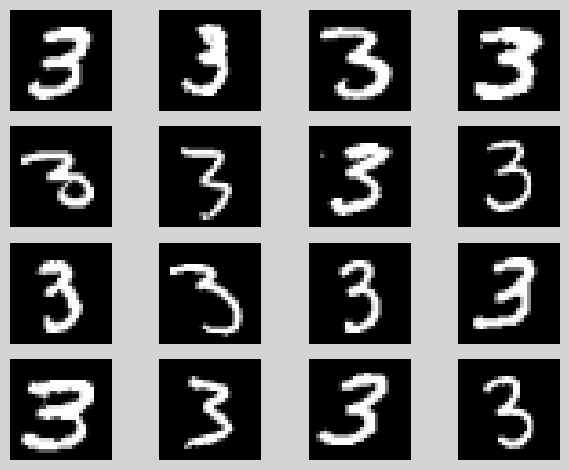

In [15]:
#Oppgave 2a)
plotimgs(train[:,3,:16], nplot = 4) #Henter ut klassen 3 og de 16 første bildene, og plotter

Ovenfor ser man nå de $16$ første hånskrevne $3$-erne i treninssettet vårt. Videre skal man nå se om projeksjonene våre av matrisene er gode representasjoner av tallene. Vi starter med $\text{SVD}$ metoden. 

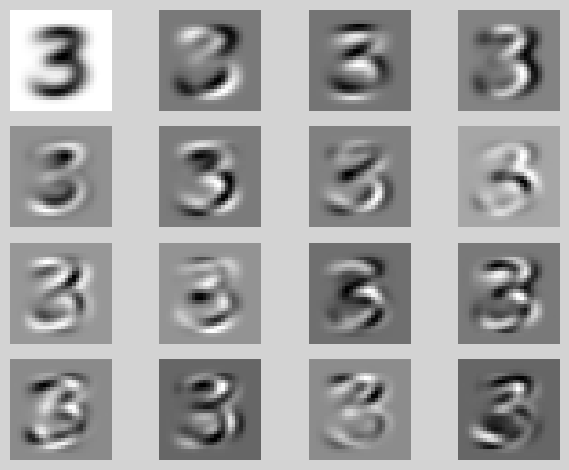

In [16]:
#oppgave 2b)
n = 3                       #Setter tallet vi vil plotte
d = 16                      #Setter antall bilder
A = train[:, n, :]          #Henter ut alle bildene av siffer "n"
U, S, Vt = np.linalg.svd(A) #Tar SVD av den fulle matrisen
plotimgs(U[:,:d]  )         #Plotter de 16 første kolonnene i U_d


Over har man plottet for $d = 16$, kolonner fra $U_d$. Man ser her at de $16$ første kolonnene representerer datasettet overraskende godt. Man ser at den første basisvektoren (projeksjonen helt øverst til venstre) har at mye sterkere omrisse av et $3$-tall kontra de andre 15. Dette gir mening fra teorien der det alltid er den første kolonnen som er viktigst for representasjonen av matrisen $A$, som i dette tilfellet er bilder av $3$-ere. Man kan tolke det første bildet som essensen av et $3$ tall, mens resten representerer ekstra karaktertrekk som går igjen. Grunnen til at de første kolonenne er viktigst er pga. den korresponderende singulærverdien, $\sigma_1, \sigma_2, ... \sigma_d$. Hvis $\sigma_1 >> \sigma_2$, vil man kunne få en god representasjon av en $3$ selv med kun én basisvektor, slik man ser i projeksjonen øverst til venstre.

Nedenfor har man plottet singulærverdiene fra matrisen $\Sigma$ på en logaritmisk skala, bestående av diagonalelementer $\sigma_1, \sigma_2, ... \sigma_d$. Disse verdiene vil være rangerte fra størst til minst. 

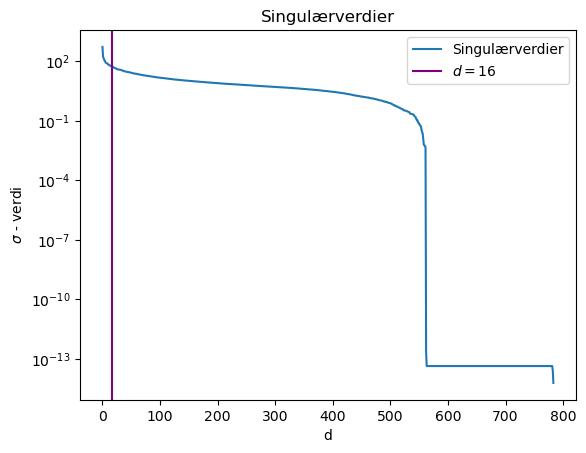

In [17]:
plt.semilogy(S, label = "Singulærverdier")              #Plotter singulærverdiene
plt.axvline(x=16, label = r"$d = 16$", color ="purple") #Setter inn en linje for d = 16
plt.xlabel("d")
plt.ylabel(r"$\sigma$ - verdi")
plt.title(r"Singulærverdier")
plt.legend()
plt.show()

I plottet over ser man alle de $784$ singulærverdiene for matrisen $A$, bestående av $5000$ bilder av $3$. Man ser på plottet at de første singulærverdiene er veldig store, der $\sigma_1 \approx 1000$. Likevel er $\sigma_d, d = 1,2,...,784$ av relevant størrelse helt til rundt $d = 550$. Siden de $16$ første $\sigma$-verdiene kan man få et brukbartbilde av et $3$-tall, men for de mest unike $3$-tallene burde man ha $d = 550$ kolonnener for representasjonen. Likevel kan man argumentere for at ca. de $40$ første kolonnene er de som er mest relevante for representasjonen av et generelt $3$-tall.

I kodeblokken under skal man se nærmere på om $d = 16$ er en god nok tilnærming for å representere bildet.

In [18]:
def plotSVD_d(number, b_thilde_number, U):
    i = 2                                         # Setter i = 2 for å få riktig startplott                          
    D = [16, 32, 64, 128, 256, 512, 768]          #Liste med antall kolonner man bruker i plottet
    b = A[:,0]                                    #Henter ut første kolonne fra A
    b_thilde = train[:, b_thilde_number, :][:,0]  #Henter ut første kolonne av det andre tallet
    
    #Plotter for startverdier
    fig,ax=plt.subplots(nrows = 1,ncols = len(D) +1,figsize=(16,10))
    plt.subplot(1,len(D) +1,1)
    plt.imshow(b_thilde.reshape((28, 28)), cmap = 'gray', extent = (0,28,0,28))
    
    #Plotter for de andre d-verdiene
    for d in D:
        W = U[:,:d]                                #Finner basisvektorene
        P_w = orthproj(b_thilde, W)                #Projeserer
        ax = plt.subplot(1,len(D) + 1, i)
        ax.title.set_text(f'd = {d}')
        plt.imshow(P_w.reshape((28, 28)), cmap = 'gray', extent = (0,28,0,28))
        i+=1

In [19]:
A = train[:, 3, :]             #Henter ut tallet number fra training fil
U, S, Vt = np.linalg.svd(A)    #Tar SVD av matrisen A

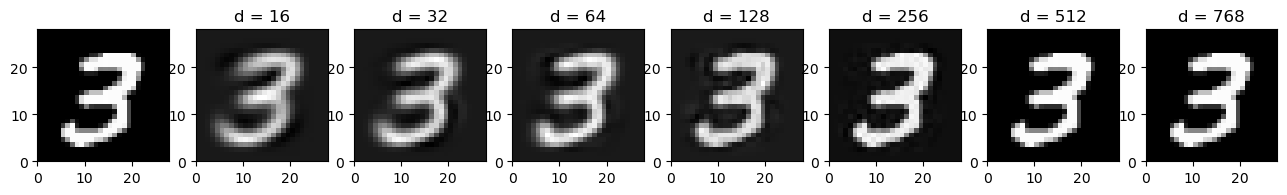

In [20]:
#Projeserer ett tre-tall med en trent basis på 3
plotSVD_d(3,3, U) 

Man ser at projeksjonen av tallet er god med $d = 32$. For $d = 16$ er bildet noe mer uklart som forventet fra diskusjonen over. Fra plottet over singulærverdiene så man at $\sigma_d$ minket betraktelig rundt $d = 540$, noe man ser igjen i plottet for $d = 512$ og $d = 768$, der disse er visuelt helt identiske. Så man vet nå at projeksjonene gir gode representasjoner av tallene ved høye $d$-verdier. 

Man vil nå sjekke hvordan dette blir hvis man starter med et annet tall enn det $W$ er trent på. Dette skal man finne svar på i kodeblokken under.

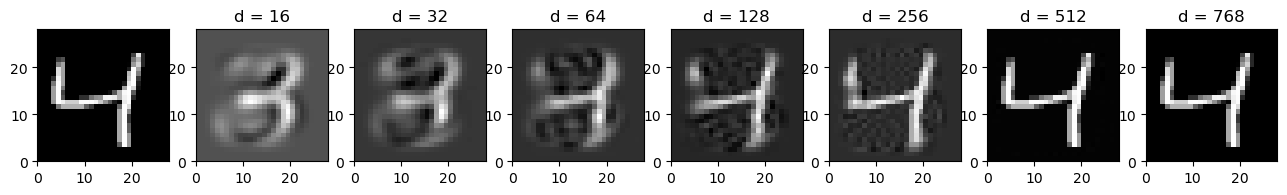

In [21]:
#W er trent på 3, og b_thilde er 4
plotSVD_d(3,4, U)

I plottet har man projesert et $4$ tall på en $3$-er basis. Her ser man at for $d = 16$ og $d = 32$ kolonner har man fortsatt omrisset av $3$ tallet, men det blir raskt til et $4$ tall når $d$ øker. Når $d = 256$  så er det umulig å avgjøre hvilken basis tallet er trent på. 

Fra plottene over kan man si at de mest spesifikke plottene for hver basis kommer for $d = 16$ og $d = 32$. Blir $d$ større enn $32$ vil spennet bli så generelt at man vil nå alle basisene, og dermed mister konturene av tallet. Dette kan være viktig å tenke på når man senere skal klassifisere data.

Nå skal man videre se på avstanden mellom projeksjon og opprinnelig matrise.

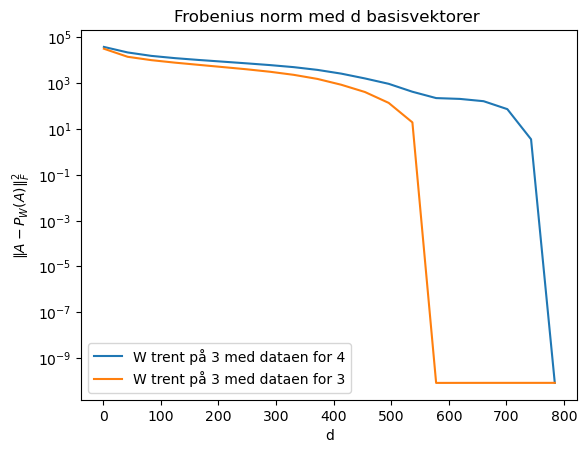

In [22]:
#oppgave 2d 
def PlotFrobeniusNorm(new_number): #New number er tallet man ønsker å sammenligne 3-er basisen med
    #Lager grid
    D = np.linspace(1, 784, 20) 
    
    #Henter ut klassen for det nye tallet
    B = train[:, new_number, :]
    
    #Bruker tallet 3, siden dette er den basisen vi allerede har laget
    number = 3

    #Finner distansen for de to ulike tilfellene
    distance = np.zeros(len(D))
    distance_trained = np.zeros(len(D))
    i = 0
    for d in D: 
        #Finner distansen når starttall og W er trent på det samme
        distance_trained[i] = np.sum(columnDistance(A, U[:, :int(d)])) 
        
        #Finner distansen når de ikke er trent på det samme tallet
        distance[i] = np.sum(columnDistance(B, U[:, :int(d)]))
        i+=1
    
    #Plotter
    plt.semilogy(D, distance, label = f"W trent på {number} med dataen for {new_number}")
    plt.semilogy(D, distance_trained, label = f"W trent på {number} med dataen for {number}")
    plt.xlabel("d")
    plt.ylabel(r"$∥ A−P_W (A)∥_F^2$")
    plt.title("Frobenius norm med d basisvektorer ")
    plt.legend()
    plt.show()

    
PlotFrobeniusNorm(4)

Når $W$ og testdataen $A$ er basert på samme tall ser man at plottet nesten er identisk med plottet for singulærverdiene. Når singulærverdiene blir små vil ikke tilhørende kolonnevektor være en god representasjon for et generelt siffer. Dermed vil basisen nå alle tall av datatypen med god tilnærmelse, og $∥ A−P_W (A)∥_F^2 \approx ∥ A−A∥_F^2 = 0$. Derimot når $W$ er trent på et annet tall enn datatypen vil differansen mellom projeksjonen og tallet den prøver å projesere være større hele veien, og den vil konvergere saktere mot tallet. Dette støtter opp om det man så i forrige kodeblokk, der man trengte en større $d$ for å få representert tallet man ønsket når $W$ var trent på et annet tall. 


Til nå har man kun brukt $\text{SVD}$ metoden, men nå skal vi ta i bruk $\text{ENMF}$.

ENMF:


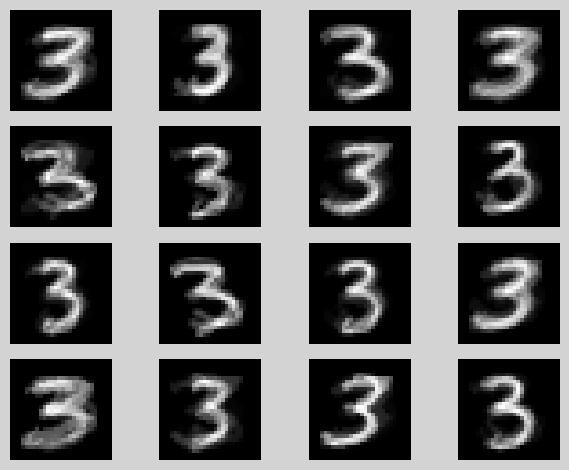

SVD:


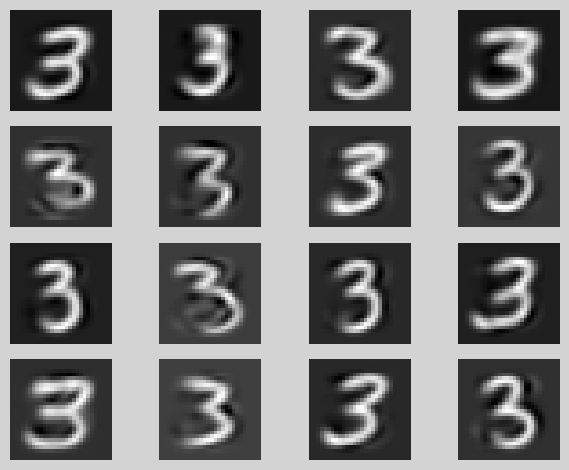

In [23]:
#oppgave 2e 
#Funksjonen tar inn ønsket tall, d kolonner, max antall iterasjooner, delta for å unngå å dele på 0
def plotENMF(number, d, maxIter, delta):
    A = train[:, number, :]                                      #Lager datasettet
    randint = np.random.choice(A.shape[1], d, replace = False)   #Lager en random liste med lengde d
    W_plus = A[:,randint]                                        #Henter ut de tileldige kollonner fra datasett A
    U,S,Vt = np.linalg.svd(A)                                    #Tar SVD for sammenligning
    P_W = orthproj(A, U[:,:d])                                   #Finner ortogonal projeksjon
    P_W1, H = nnproj(A, W_plus, maxIter, delta)                  #Finner den ikke-negative projeksjonen 

    #Plotter
    print("ENMF:")
    plotimgs(P_W1[:, :16], 4)
    print("SVD:")
    plotimgs(P_W[:, :16], 4)
    
plotENMF(3,32, 100, 1e-10)

Man ser at plottene for $\text{SVD}$ projeksjonen er betydelig nærmere, enn plottet fra $\text{EMNF}$ projeksjonen. Dette skyldes som diskutert tidligere at $\text{SVD}$ trenger færre basisvektorer for å få et presist bilde, siden de første basisvektorene er de viktigste. I $\text{EMNF}$ basisen har man hentet ut $32$ tilfeldige kolonner, men disse trenger ikke å være en god representasjon for datatypen. 

Hvor nært projeksjonene er den opprinnelige matrisen finner man med Frobeniusnormen av matrisen og projeseringen, altså:

$$∥A−P_W (A)∥_F^2.$$

Dette undersøker vi i kodeblokken under.

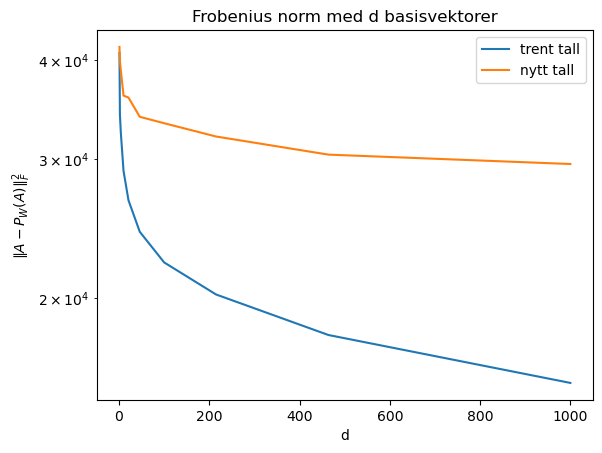

In [24]:
def PlotFrobeniusNormNN(number, new_number):
    #Lager grid
    D = np.logspace(0,3,10, dtype = np.int64)
    
    #Henter ut klassen for tallet
    A = train[:, number, :]
    #Henter ut klassen for det nye tallet
    B = train[:, new_number, :]
    
    #Finner distansen for de to tilfellene
    distance_trained = np.zeros(len(D))
    distance_new = np.zeros(len(D))
    i = 0
    for i in range(len(D)):
        #Lager W_plus
        randint = np.random.choice(A.shape[1], D[i], replace = False)
        W_plus = A[:,randint]
        
        #Finner distansene
        distance_trained[i] = np.sum(nncolumnDistance(A, W_plus, 50, 1e-10)) 
        distance_new[i] = np.sum(nncolumnDistance(B, W_plus, 50, 1e-10))
        
    
    #Plotter for tallene
    plt.semilogy(D, distance_trained, label = "trent tall")
    plt.semilogy(D, distance_new, label = "nytt tall")
    plt.xlabel("d")
    plt.ylabel(r"$∥ A−P_W (A)∥_F^2$")
    plt.title("Frobenius norm med d basisvektorer")
    plt.legend()
    plt.show()


PlotFrobeniusNormNN(3, 4)

Man observerer tydelig at ved liten $d$ vil avstanden mellom opprinnelig matrise og projeksjon være av samme størrelsessorden for begge tallene. Etterhvert som $d$ øker ser man at avstanden mellom projeksjonen for det trente tallet og opprinnelig datasett minker betraktelig. For det nye tallet vil denne avstanden minke mye tregere enn for det trente tallet. Med dette kan man konkludere med at en større $d$ vil gi mye bedre tilnærmelse med det trente tallet enn med et utrent tall. Dette står i kontrast til $\text{SVD}$ der normen går mot $0$ både for trent og utrent tall, ved stor $d$. Det er vært å notere at disse plottene vil variere fra gang til gang, siden basisvektorene trekkes tilfeldig. Likevel ser man de samme tendensene hver gang.

Videre skal man nå se på hvordan man kan bruke denne avstanden til å predikere tallene ut i fra projeksjonen. Man tar nå inn store mengder rådata for hvert tall, og bruker dette til å danne basiser for hvert siffer. Projeksjonene våre bør ligge nermest mulig sifferets tilhørende basis. Ved å se på kolonnevektoren til et nytt bilde, kan man sammenligne avstanden til ulike basiser, og predikere sifferet ved å finne den basisen med minst avstand. 

Til å begynne med lager vi basiser for de ulike tallene med oppgitt rådata, både for $\text{SVD}$- og $\text{ENMF}$ metoden.

In [25]:
#Utdelt kode for å generere tester
def generate_test(test, digits = [0,1,2], N = 800):
    """
    Randomly generates test set.
    input:
        test: numpy array. Should be the test data loaded from file
        digits: python list. Contains desired integers
        N: int. Amount of test data for each class
    output:
        test_sub: (784,len(digits)*N) numpy array. Contains len(digits)*N images
        test_labels: (len(digits)*N) numpy array. Contains labels corresponding to the images of test_sub
    """

    assert N <= test.shape[2] , "N needs to be smaller than or equal to the total amount of available test data for each class"

    assert len(digits)<= 10, "List of digits can only contain up to 10 digits"

    # Arrays to store test set and labels
    test_sub = np.zeros((test.shape[0], len(digits)*N))
    test_labels = np.zeros(len(digits)*N)

    # Iterate over all digit classes and store test data and labels
    for i, digit in enumerate(digits):
        test_sub[:, i*N:(i+1)*N] = test[:,digit,:]
        test_labels[i*N:(i+1)*N] = digit

    # Indexes to be shuffled 
    ids = np.arange(0,len(digits)*N)

    # Shuffle indexes
    np.random.shuffle(ids)

    # Return shuffled data 
    return test_sub[:,ids], test_labels[ids]

Over har man brukt utdelt kode, som lager en testarray med $N$ ulike bilder, og med $d$ typer klasser. Nedenfor lager man testsettet man skal teste mot, både for den ikke negative projeksjonen og for $\text{SVD}$ metoden.

In [26]:
def create_dictionaries_SVD(d):
    """
    Lager basisene for redusert SVD-metoden for alle tall/klasser fra 0-9 
    input:
        d, antall kollonnevektorer vi ønsker å hente ut 
    output:
        List_of_dictionaries: alle basisene for hver klasse 
    """
    List_of_dictionaries = []
    for i in range(10):
        A = train[:, i, :]                                 #Itererer gjennom klassene 
        U, S, Vt = np.linalg.svd(A)                        #Tar SVD
        W, H = TruncSVD(U, np.diag(S), Vt, d)              #Tar å fjerner rader man ikke trenger
        List_of_dictionaries.append(W)                     #Legger inn basisvektorene
    List_of_dictionaries = np.array(List_of_dictionaries)
    return List_of_dictionaries


In [27]:
def create_dictionaries_nn(d):
    """
    Lager basisene for ENMF-metoden for alle tall/klasser fra 0-9 
    input:
        d, antall kollonnevektorer vi ønsker å hente ut 
    output:
        List_of_dictionaries: alle basisene for hver klasse 
    """
    List_of_dictionaries = []
    for i in range(10):
        A = train[:, i, :]                                           #Henter ut rådata
        randint = np.random.choice(A.shape[1], d, replace = False)   #Lager en basis opp til d kolonner
        W_plus = A[:,randint]                                        #Henter ut ønskede kollonner 
        List_of_dictionaries.append(W_plus)                          #Legger til basisen for hvert siffer
    List_of_dictionaries = np.array(List_of_dictionaries)            #Gjør det om til array for senere bruk
    return List_of_dictionaries

In [28]:
#Lager store basiser i starten, som man heller kan slice når nødvendig.
#Dette tar lang tid med stor d og dermed ønsker man å gjøre dette kun en gang.
dictionary_nn = create_dictionaries_nn(d = 784)
dictionary_SVD = create_dictionaries_SVD(d = 784)

Når man nå har laget testsettene våre kan man nå begynne å klassifisere tallene. Lager derfor en funksjon som kan predikere tall basert på avstand til de ulike basisene.

In [29]:
def classification(B, dictionary_SVD, dictionary_nn, delta = 1e-10):
    """
    klassifiserer tall 
    input:
        B: matrise med tall vi ønsker å klassifisere 
        dictionary_SVD: basiser for klasse med SVD-metoden 
        dictionary_nn: basiser for klasse med ENMF-metoden 
    output:
        predicted_number_svd: klassifisering av hvert tall med SVD-metoden 
        predicted_number_nn: klassifisering av hvert tall med ENMF-metoden 
    """
    distance_to_basis_svd = []
    distance_to_basis_nn = []

    for i in range(10):
        #Legger inn kolonnedistansen til hver av klassene
        distance_to_basis_svd.append(columnDistance(B, dictionary_SVD[i]))             
        distance_to_basis_nn.append(nncolumnDistance(B, dictionary_nn[i],50, delta))
    
    #Finner indexen, altså tallet som har kortest avstand til klassen
    predicted_number_svd=np.argmin(np.array(distance_to_basis_svd),axis=0)
    predicted_number_nn=np.argmin(np.array(distance_to_basis_nn),axis=0)

    #Returnerer det tallet som ligger nærmest klassen
    return predicted_number_svd, predicted_number_nn


Videre kan man nå teste hvor mange prediksjoner som er riktig i forhold til hvor mange prediksjoner man har tatt. Dette vil være treffsikkerheten til funksjonen vår;
$$\text{accuracy} = \frac{\text{antall riktige prediksjoner}}{\text{totalt antall prediksjoner}},$$
som beskrevet av fuksjonen nedenfor.

In [30]:
def accuracy(A_labels,predicted_label_svd,predicted_label_ENMF,number_of_pictures, output = False):
    """
    beregner nøyaktigheten til en klassifisering
    input:
        A_labels: fasiten/kalssen til alle tallene
        predicted_label_SVD: array med klassifisering med SVD metoden 
        predicted_label_ENMF:array med klassifisering med ENMF metoden
        number_of_pictures: antall bilder som skal sjekkes 
        output: bool som sjekker om vi skal skrive ut nøyaktighet 
    output: 
        P_SVD: andel riktige klassifiseringer med SVD-metode 
        P_nn: andel riktige klassifiseringer med ENMF-metode 
        feil_gjett_SVD: posisjonen til feil gjett i predicted_label_svd 
        feil_gjett_nn: posisjonen til feil gjett i predicted_label_nn 
    """
    korrekt_gjett_svd=0
    korrekt_gjett_nn=0
    feil_gjett_svd = [] #liste som inneholder indeksene der vi har gjettet feil i vector_svd 
    feil_gjett_nn = [] ##liste som inneholder indeksene der vi har gjettet feil i vector_nn
    
    for i in range(number_of_pictures):         #itererer gjennom bildene vi analyserer 
        if A_labels[i]==predicted_label_svd[i]: #test som sjekker om vi har riktig gjett for SVD-metoden
            korrekt_gjett_svd+=1                #legger til et rett om riktig 
        else:
            feil_gjett_svd.append((i,predicted_label_svd[i])) #henter ut posisjonen og fasit til feil gjett og lagrer den til senere 
        
        if A_labels[i]==predicted_label_ENMF[i]: #samme test for ENMF
            korrekt_gjett_nn+=1
        else:
            feil_gjett_nn.append((i, predicted_label_ENMF[i]))
    
    P_SVD, P_nn = korrekt_gjett_svd/number_of_pictures, korrekt_gjett_nn/number_of_pictures #Andel riktige gjett for SVD og ENMF
    if(output): #Printer ut hvis kallet på funksjonen ønsker det 
        print(f'Accuracy of classification method:')
        print(f'SVD, ENMF = [{P_SVD:0.4f} , {P_nn:0.4f}]\n')
    feil_gjett_svd, feil_gjett_nn = np.array(feil_gjett_svd), np.array(feil_gjett_nn) #gjør om til array for bedre funksjonalitet seneree
    return P_SVD, P_nn, feil_gjett_svd, feil_gjett_nn


I tillegg til treffsikkerheten til alle tallene, kan man teste treffsikkerheten til et enkelt tall. Dette blir kalt for "recall": 

$$\text{recall} = \frac{\text{antall riktige prediksjoner av tallet}}{\text{totalt antall av tallet}},$$

nedenfor har man laget denne fuksjonen.

In [31]:
def recall(A_labels, predicted_label_svd,predicted_label_ENMF,number_of_pictures, digits, output = False):
    """
    beregner antall ganger algoritmen gjetter riktig for hver klasse/tall 
    input:
        A_labels: fasiten/kalssen til alle tallene
        predicted_label_SVD: array med klassifisering med SVD metoden 
        predicted_label_ENMF:array med klassifisering med ENMF metoden
        number_of_pictures: antall bilder som skal sjekkes 
        digits: hvilke tall som skal sjekkes
        output: bool som sjekker om vi skal skrive ut nøyaktighet 
    output: 
        recall_SVD: andel riktige klassifiseringer med SVD-metode for alle tall i digits
        recall_nn: andel riktige klassifiseringer med ENMF-metode for alle tall i digits
    """
    recall_SVD = [] #Tom liste med recall for alle klassene med SVD-metoden 
    recall_nn = [] #Tom liste med recall for alle klassene med ENMF-metoden  
    for k in digits:    
        n = 0           #Antall for hver klasse i A_labels 
        correct_SVD = 0 #Nullstilling av rikitge gjett for SVD
        correct_nn = 0  #Nullstilling av rikitge gjett for ENMF
        for i in range(number_of_pictures):                                   #Itererer gjennom alle bildene 
            if(A_labels[i] == k):                                             #Teller antall innstanser av hver klasse
                n+=1
            if(A_labels[i] == vector_svd[i] and predicted_label_svd[i]  == k):#Test som sjekker om gjettet til SVD-algoritmen er riktig 
                correct_SVD +=1

            if(A_labels[i] == vector_nn[i] and predicted_label_ENMF[i]  == k):#Test som sjekker om gjettet til ENMF-algoritmen er riktig 
                correct_nn +=1     
        recall_SVD.append(correct_SVD/n)                                      #Legger til recall for SVD
        recall_nn.append(correct_nn/n)                                        #Legger til recall for SVD
    
    recall_SVD, recall_nn = np.array(recall_SVD), np.array(recall_nn)         #Gjør om til array for funksjonalitet senere 
    if(output):                                                               #Skriver ut tabell hvis kallet på funksjonen ønsker det 
        print(f'Recall of each digit:')                                       #Passende utskrift til skjerm 
        print(f'| Class |  SVD  | |  ENMF |')                                 #Toppen av tabell
        for i in range(len(recall_SVD)):                                      #For loop som printer tabell 
            print(f'|   {digits[i]:0.0f}   | {recall_SVD[i]:0.4f}| | {recall_nn[i]:0.4f}|')
            
    return recall_SVD, recall_nn       

Nå har man alle funksjonene man trenger for å finne recall og accuracy til prediksjonene våre. Man tester nå funksjonene våre for både $\text{SVD}$ og $\text{ENMF}$, med ulike $d$ verdier.

In [32]:
#3b)
d = 32                                              #Antall kolloner vi vil lage/hente ut 
digits = [3,4,5]                                    #Tall vi ønsker å se på 
N = 800                                             #Antall bilder vi av hver klasse

A_test, A_labels = generate_test(test, digits , N)  #Henter ut testdata og fasit til hver av bildene
vector_svd, vector_nn = classification(A_test[:, :N], dictionary_SVD[:,:,:d], dictionary_nn[:,:,:d]) #Genererer gjett
accuracy(A_labels, vector_svd, vector_nn, N, True) #Printer ut den overordnede nøyaktigheten til gjettene 
recall(A_labels, vector_svd, vector_nn, N, digits, True); #Printer ut nøtaktigheten for hver klasse til gjettene

Accuracy of classification method:
SVD, ENMF = [0.9463 , 0.8475]

Recall of each digit:
| Class |  SVD  | |  ENMF |
|   3   | 0.9283| | 0.8717|
|   4   | 0.9745| | 0.7956|
|   5   | 0.9349| | 0.8774|


Når begge metodene bruker $d = 32$ kolonner er $\text{SVD}$ helt klart best. Treffsikkerheten for $\text{SVD}$ ligger på godt over $90 \%$ for denne $d$ verdien. Dette stemmer godt overens med resultatene man så i tidligere diskusjon.  $\text{ENMF}$ verdien ligger under $90 \%$, men dette er også forventet for lave $d$ verdier. Dermed prøver man å øke $d$ verdien for begge metodene.

In [33]:
digits = [3,4,5] #Tallene vi ønsker å  se på 
d = 550 #Antall kollonner i hver basis 
N = 800 #Antall bilder 

A_test, A_labels = generate_test(test,  digits, N) #Genererer testdata og fasit 
vector_svd, vector_nn = classification(A_test[:, :N], dictionary_SVD[:,:,:d], dictionary_nn[:,:,:d]) #Henter gjett 
accuracy(A_labels, vector_svd, vector_nn, N, True) #Beregner nøyaktigheten til SVD og ENMF og plotter i tabell 
recall(A_labels, vector_svd, vector_nn, N, digits, True); #Regner nøyaktigheten til SVD og ENMF for hver klasse 

Accuracy of classification method:
SVD, ENMF = [0.0100 , 0.9712]

Recall of each digit:
| Class |  SVD  | |  ENMF |
|   3   | 0.0301| | 0.9474|
|   4   | 0.0000| | 0.9823|
|   5   | 0.0000| | 0.9841|


Hvis man øker $d$ kolonner man trekker fra test matrisen, blir $\text{ENMF}$ metoden veldig bra, med sannsynlighet på godt over $95 \%$. Derimot blir $\text{SVD}$ metoden helt ubrukelig. Som tidligere diskutert vil ikke $\text{SVD}$ metoden kunne skille mellom de ulike basisene for høye $d$ verdier.

Fra resultatene over ser man at de ulike metodene presterer best for ulike $d$ verdier.  $\text{SVD}$ metoden fungerer best for rundt $d = 32$, mens $\text{ENMF}$ metoden presterer best for store $d$ verdier, f.eks. $d = 550$. Man ser at "accuray" og "recall" for de ulike tallene variere litt, men er en ubetydelig forskjell i forhold til $d$ verdien. Variasjonen kan skyldes likhet i ulike tall, f.eks. $5$ og $6$. 

Videre kan man se på hvilket av bildene som er det beste tallet, altså det bildet som ligger nermest tilhørende basis. I tillegg skal vi finne et tall som er blitt mistolket, og sammenligne det opprinnelige bildet med det projeserte bilde. 

In [34]:
def plot_most_least_likely(A_test, A_label, d, digits,n, output = False ):
    """
    plotter tallene som er nærmest og lengst unna med SVD og ENMF metoden

    input: 
        A_test: tall som skal testes 
        A_label: fasit/klasene for alle tallene 
        d: antall kollonner vi ønsker å regne med 
        digits: hvilke tall vi ønsker å se på 
        n: andel av A_test vi ønsker å beregne for
        output: bool som aktiverer print av accuracy og recall  
    """
    vektor_svd, vektor_nn=classification(A_test[:,:n], dictionary_SVD[:,:,:d], dictionary_nn[:,:,:d]) #bruker SVD og ENMF for å klassifisere 
    P_SVD, P_nn, miscalculated_SVD, miscalculated_nn = accuracy(A_labels,vektor_svd,vektor_nn,n, output) #henter ut sannsynligheter, og feilkalkulert tall
    recall_SVD, recall_NN = recall(A_labels, vektor_svd, vektor_nn, n, digits, output) #beregner recall-verdier fra recall-funksjon    
    
    distance_SVD =columnDistance(A_test, dictionary_SVD[digits[0],:,:d]) #avstand til hver av basisene i SVD  
    distance_NN = nncolumnDistance(A_test, dictionary_nn[digits[0],:,:d], 50, 1.0E-10) #avstand til hver av basisene i ENMF 
    label1 = 0 
    label2 = 0 
    
    #for løkke som finner ut av hvilken korteste distanse og med det "most likely integer"
    for i in digits[0:]: 
        
        #Oppdaterer den minste distansen hvis ny distanse er mindre enn tidligere distanse
        if(np.min(distance_SVD) > np.min(columnDistance(A_test, dictionary_SVD[i,:,:d]))):
            distance_SVD = columnDistance(A_test, dictionary_SVD[i,:,:d])
            label1 = i 
            
        #Oppdaterer den minste distansen hvis ny distanse er mindre enn tidligere distanse
        if(np.min(distance_NN) > np.min(nncolumnDistance(A_test, dictionary_nn[i,:,:d], 50, 1.0E-10))):
            distance_NN = nncolumnDistance(A_test, dictionary_nn[i,:,:d], 50, 1.0E-10)
            label2 = i  
    index1 = np.argmin(distance_SVD)
    index2 = np.argmin(distance_NN)

    fig, axs = plt.subplots(2,2, figsize = (10,10)) #plotter tallene som er best kalkulert 
    plt.subplot(2,2,1) 
    plt.title(f'"Most likely" integer for SVD ') 
    plt.imshow(A_test[:,index1].reshape((28,28)), cmap = 'gray') #tallet i SVD som er best 
    plt.subplot(2,2,2)
    plt.title(f'"Most likely" integer projected in U') 
    plt.imshow(orthproj(A_test[:,index1], dictionary_SVD[label1,:,:d]).reshape((28,28)), cmap = 'gray', extent = (0,28,0,28)) #projeksjonen ned i U 

    plt.subplot(2,2,3)
    plt.title(f'"Most likely" integer for ENMF')
    plt.imshow(A_test[:,index2].reshape((28,28)), cmap = 'gray') #tallet som er best i ENMF 
    plt.subplot(2,2,4)
    plt.title(f'"Most likely" integer projected in ENMF')
    P_W,H = nnproj(A_test, dictionary_nn[label2,:,:d], 50, 1.0e-10) #projeksjonen ned i W_plus
    plt.imshow(P_W[:,index2].reshape((28,28)), cmap = 'gray') 

    fig, axs = plt.subplots(2,2, figsize = (10,10)) #ønsker her å plotte tall som har blitt tolket feil 
    plt.subplot(2,2,1)
    plt.title(f'Correct: {A_labels[miscalculated_SVD[0][0]]}') 
    plt.imshow(A_test[:, miscalculated_SVD[0][0]].reshape((28,28)), cmap = 'gray')
    plt.subplot(2,2,2)
    plt.title(f'Calculated SVD: {miscalculated_SVD[0][1]}')
    plt.imshow(orthproj(A_test[:, miscalculated_SVD[0][0]], dictionary_SVD[miscalculated_SVD[0][1],:,:d]).reshape((28,28)), cmap = 'gray')

    plt.subplot(2,2,3)
    plt.title(f'Correct: {A_labels[miscalculated_nn[0][0]]}')
    plt.imshow(A_test[:, miscalculated_nn[0][0]].reshape((28,28)) , cmap = 'gray')
    plt.subplot(2,2,4)
    plt.title(f'Calculated ENMF: {miscalculated_nn[0][1]}')
    P_W, H = nnproj(A_test, dictionary_nn[miscalculated_nn[0][1],:,:d], 50, 1.0e-10)
    plt.imshow(P_W[:, miscalculated_nn[0][0]].reshape((28,28)), cmap = 'gray')


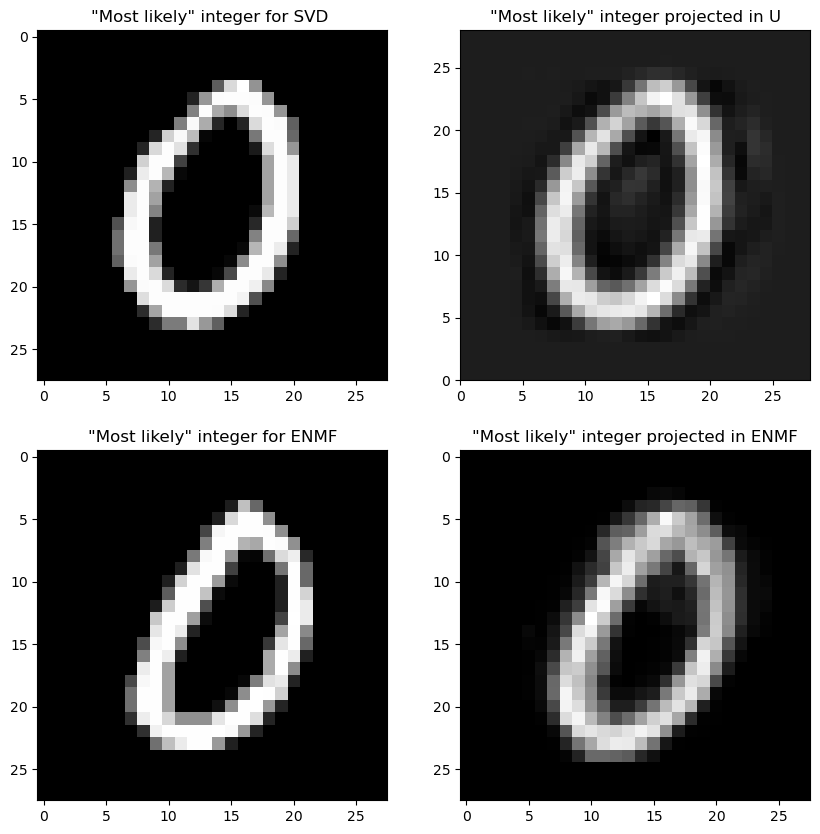

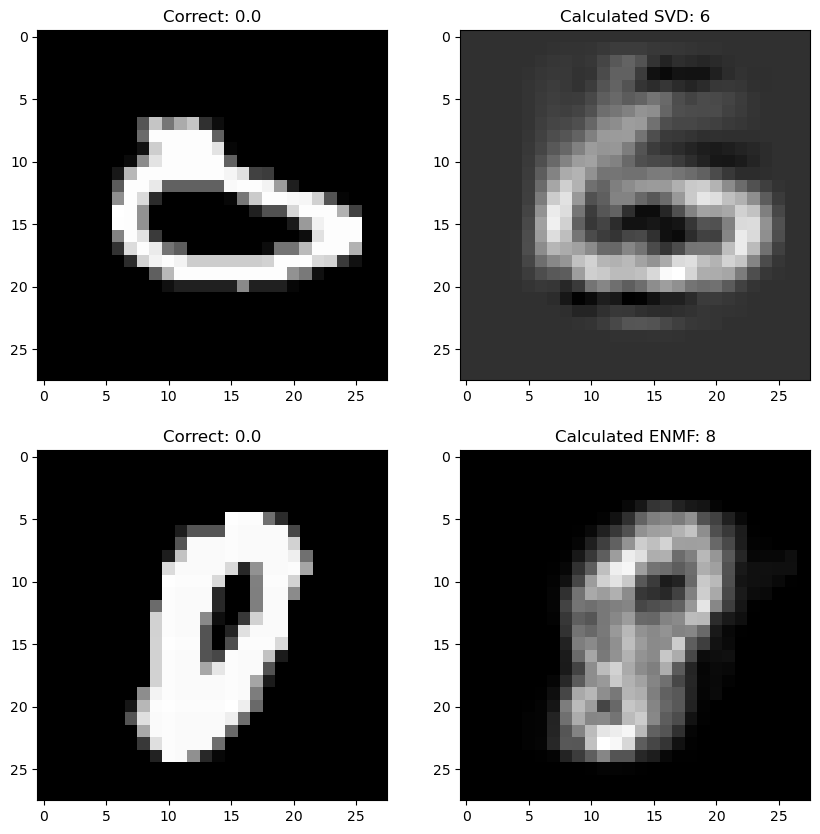

In [35]:
#3c),d)e)
digits = [0]
n = 800
A_test, A_labels = generate_test(test,  digits, N = 800)
#dictionary_SVD, dictionary_nn = create_dictionaries_SVD(d = 32), create_dictionaries_nn(d = 32)
plot_most_least_likely(A_test, A_labels, 32, digits, n)

Fra plottet observerer vi at bildet som ligger nærmest egen basis, nesten ikke endrer seg i projeksjonen. Forskjellen på det beste og det dårligste tallet, er at det dårligste tallet er skrevet på en unik måte, som ikke ligner på resterende bilder av datatypen.  Observerer også at tallene som blir mistolket ligner på et annet siffer allerede før projeksjonen, og dermed fort kan mistolkes av både algoritmen og mennesker. 

Kan nå prøve å legge til alle de ekstra tallene til digits, slik at man nå vil prediktere ti ulike tall og ikke bare tre. Nedenfor tester vi, med $d = 32$ for $\text{SVD}$  og $d = 550$ for $\text{ENMF}$.

In [36]:
digits = [0,1,2,3,4,5,6,7,8,9]
N = 800
A_test, A_labels = generate_test(test,  digits, N)
vector_svd, vector_nn = classification(A_test[:, :N], dictionary_SVD[:,:,:32], dictionary_nn[:,:,:550])
accuracy(A_labels, vector_svd, vector_nn, N, True)
recall(A_labels, vector_svd, vector_nn, N, digits, True);


print("\n")
digits = [3,4,5]
N = 800
A_test, A_labels = generate_test(test,  digits, N)
vector_svd, vector_nn = classification(A_test[:, :N], dictionary_SVD[:,:,:32], dictionary_nn[:,:,:550])
accuracy(A_labels, vector_svd, vector_nn, N, True)
recall(A_labels, vector_svd, vector_nn, N, digits, True);

Accuracy of classification method:
SVD, ENMF = [0.9487 , 0.9637]

Recall of each digit:
| Class |  SVD  | |  ENMF |
|   0   | 1.0000| | 1.0000|
|   1   | 0.9773| | 0.9545|
|   2   | 0.9194| | 0.9677|
|   3   | 0.9054| | 0.9595|
|   4   | 0.9753| | 0.9753|
|   5   | 0.9140| | 1.0000|
|   6   | 0.9767| | 0.9767|
|   7   | 0.9155| | 0.9155|
|   8   | 0.9694| | 0.9592|
|   9   | 0.9032| | 0.9032|


Accuracy of classification method:
SVD, ENMF = [0.9437 , 0.9688]

Recall of each digit:
| Class |  SVD  | |  ENMF |
|   3   | 0.9216| | 0.9451|
|   4   | 0.9768| | 0.9768|
|   5   | 0.9336| | 0.9825|


Man ser at sannnsynligheten er omtrent den samme hele tiden. Dette er fordi testsettet vårt består av alle tallene og ikke bare det vi skal teste. Dette betyr at uansett hvor mange tall man har i "digits" vil de kunne projeseres ned i alle basisene. Dette gjør at sannsynlighetene for å predikere korrekt tall er uavhengig av antall digits. Hvis man kun hadde lagd basisen for tallene i digits ville treffsikkerheten ha økt, da disse tallene kan projeseres til færre ukorrekte basiser. 

Man ønsker nå å avgjøre nå hvilken $d$ verdi som gir best presisjon for de to metodene. Lager derfor basiser med ulike $d$ verdier. Plotter så treffsikkerheten (accuracy) opp mot $d$ verdier for å se hvordan den endrer seg.

In [37]:
#3f
def makeDictonairy():
    D = []
    matrixes = []
    for i in range(1,11):
        D.append(2**i)
    dictionaries_svd = []
    dictionaries_nn = []

    U = []
    for i in range(10):
        A = train[:, i, :]
        u, s, vt = np.linalg.svd(A)
        dictionaries_svd.append(u)
        dictionaries_nn.append(A)
    dictionaries_svd = np.array(dictionaries_svd)
    dictionaries_nn = np.array(dictionaries_nn)
    return dictionaries_svd, dictionaries_nn, D

dictionaries_svd, dictionaries_nn, D = makeDictonairy()



In [38]:
#Finner treffsikkerheten for alle de ulike d-ene for et totalt sett med tall
digits = [0,1,2,3,4,5,6,7,8,9]
accuracies_svd = []
accuracies_ENMF = []
A_test, A_labels = generate_test(test, digits, N = 800)
for d in D:
    predicted_label_svd, predicted_label_ENMF = classification(A_test, dictionaries_svd[:,:,:d], dictionaries_nn[:,:,:d], 1e-2)
    accuracies_svd.append(accuracy(A_labels, predicted_label_svd, predicted_label_ENMF, 800)[0])
    accuracies_ENMF.append(accuracy(A_labels, predicted_label_svd, predicted_label_ENMF, 800)[1])



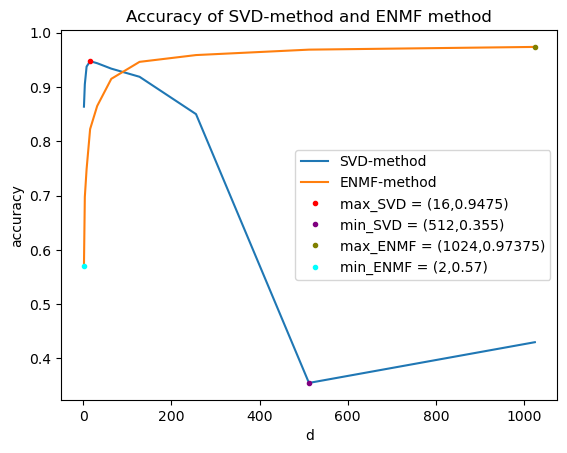

In [39]:
#Finner ekstremalpunkt
d_max_SVD = D[np.argmax(accuracies_svd)]
d_min_SVD = D[np.argmin(accuracies_svd)]
d_max_ENMF = D[np.argmax(accuracies_ENMF)]
d_min_ENMF = D[np.argmin(accuracies_ENMF)]

#Plotter ekstremalpunkt
plt.title(f'Accuracy of SVD-method and ENMF method')
plt.plot(D, accuracies_svd, label = f'SVD-method')
plt.plot(D, accuracies_ENMF, label = f'ENMF-method')

#Plotter ekstremalpunkt
plt.plot(d_max_SVD, np.max(accuracies_svd), '.',color = 'r', label = f"max_SVD = ({d_max_SVD},{np.max(accuracies_svd)})" )
plt.plot(d_min_SVD, np.min(accuracies_svd), '.',color = 'purple', label = f"min_SVD = ({d_min_SVD},{np.min(accuracies_svd)})")
plt.plot(d_max_ENMF, np.max(accuracies_ENMF), '.',color = 'olive', label = f"max_ENMF = ({d_max_ENMF},{np.max(accuracies_ENMF)})")
plt.plot(d_min_ENMF, np.min(accuracies_ENMF), '.',color = 'cyan', label = f"min_ENMF = ({d_min_ENMF},{np.min(accuracies_ENMF)})") 

plt.xlabel(f'd')
plt.ylabel(f'accuracy')
plt.legend()
plt.show()

Man observerer fra $\text{ENMF}$ øker gradvis for høyere $d$ verdier og konvergerer mot $1$. Ser også at treffsikkerheten for $\text{SVD}$ metoden er høyest for små $d$ verdier, før det når et bunnpunkt rundt $d=500$, for så å gradvis øke noe. Dette stemmer overens med tidligere observasjoner.

For små $d$ verdier vil $\text{SVD}$ metoden kun hente ut de mest spesifikke basisvektorene for den spesifikke datatypen. Etterhvert som $d$ øker vil basisen bli mer generell og dermed mister man unikheten for tilhørende siffer. Når $d$ blir større enn $550$ vil basisen begynne å dekke hele spennet til rådataen, og dermed øke treffsikkerheten noe.  Dette gjør at treffsikkerheten vil være best for små $d$ verdier, som tidligere observert. 

For små $d$ verdier vil $\text{ENMF}$ metoden hente ut få tilfeldige basisvektorer fra rådataen. Etterhvert som $d$ øker vil sannsynligheten for å få en representativ basis øke. Når alle kolonenne er brukt vil spennet dekke alle bildene nøyaktig, og treffsikkerheten må derfor konvergere mot $1$. Som tidligere observert vil avstanden for korrekt basis minke fortere enn avstanden til feil basis, dermed vil sannsynligheten for riktig prediksjon øke ganske raskt. Dette stemmer godt overens med plottet. Metoden blir altså mer presis for høyere $d$ verdier, men kjøretiden vil her bli en faktor.

For små datasett vil  $\text{SVD}$ metoden fungere bedre, med betydelig lavere kjøretid. For store datasett hvor kjøretiden ikke er en relevant faktor, vil  $\text{ENMF}$ metoden fungere bedre.

Gjennom prosjektet har man testet to ulike maskinlæringsmetoder, $\text{ENMF}$ og $\text{SVD}$. Metodene varier i hvordan de konstruerer basisen for de ulike datatypene. Man kan bruke disse basisene til å prediktere hvilken datatype ny input tilhører. Vi har observert styrker og svakheter med begge metodene. Hovedforskjellen mellom metodene er presisjonen ved ulike størrelser på basisene. Ved færre basisvektorer vil $\text{SVD}$ metoden fungere bedre, men med mange basisvektorer og ubegrenset tid vil $\text{ENMF}$ metoden fungere best. Ved selvkjørende bilder ville vi brukt $\text{SVD}$ metoden siden kjøretiden må være svært kort med høy treffsikkerhet. Hvis man f.eks. skal detektere kreftsvulster ville vi brukt $\text{ENMF}$ metoden da presisjon er viktigst og kjøretid er mindre relevant.